# 21 — Financial Plots (Candlestick, OHLC, Indicators)

## Overview
This notebook shows how to create classic **financial charts** in Matplotlib: OHLC/candlesticks and common technical indicators (SMA/EMA/RSI, volume).

### What you'll learn
- OHLC data structure
- Candlesticks (pure Matplotlib)
- OHLC bars
- Indicators: SMA, EMA, RSI
- Multi-panel layouts: price + volume + indicator

> Note: If `mplfinance` is available, it can simplify candlesticks, but this notebook also shows a dependency-free approach.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

%matplotlib inline
np.random.seed(42)
print('✅ Setup complete')

✅ Setup complete


## 1. Create Sample OHLCV Data
We'll generate synthetic OHLCV data to keep the notebook self-contained.


In [2]:
n = 120
dates = pd.date_range('2024-01-01', periods=n, freq='D')

# Random-walk close
close = 100 + np.cumsum(np.random.normal(0, 1.2, size=n))
open_ = np.r_[close[0], close[:-1]] + np.random.normal(0, 0.6, size=n)
high = np.maximum(open_, close) + np.abs(np.random.normal(0.8, 0.4, size=n))
low = np.minimum(open_, close) - np.abs(np.random.normal(0.8, 0.4, size=n))
volume = (np.random.lognormal(mean=12, sigma=0.35, size=n)).astype(int)

df = pd.DataFrame({'Open': open_, 'High': high, 'Low': low, 'Close': close, 'Volume': volume}, index=dates)
df.head()

,Open,High,Low,Close,Volume
2024-01-01,101.070676,101.553668,99.588318,100.596057,155628
2024-01-02,100.050425,101.184245,98.637329,100.430140,116490
2024-01-03,101.271816,102.273811,100.450870,101.207366,92757
2024-01-04,100.366255,104.181304,99.405571,103.035002,174767
2024-01-05,103.387116,103.706998,101.677960,102.754018,124901


## 2. Candlestick Chart (Pure Matplotlib)
A candlestick consists of:
- **Body**: Open→Close (green if close ≥ open, else red)
- **Wick**: Low→High

### Minimal implementation idea
- Plot a vertical line (wick)
- Plot a rectangle (body)


=== CANDLESTICK (PURE MATPLOTLIB) ===


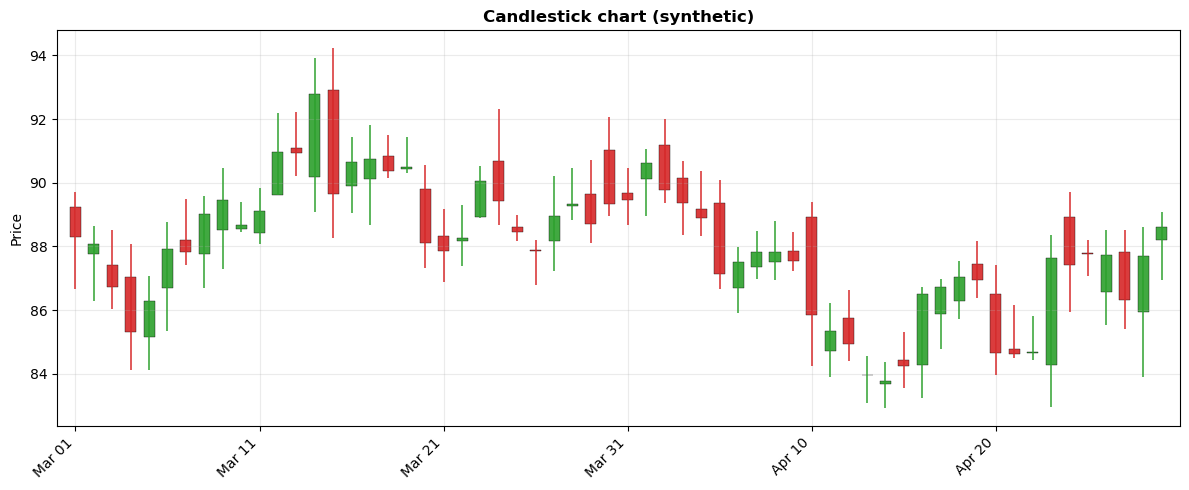

In [3]:
def plot_candles(ax, ohlc: pd.DataFrame, width=0.6, up='#2ca02c', down='#d62728'):
    x = np.arange(len(ohlc))
    for i, (op, hi, lo, cl) in enumerate(ohlc[['Open','High','Low','Close']].to_numpy()):
        color = up if cl >= op else down
        # wick
        ax.vlines(i, lo, hi, color=color, linewidth=1.2, alpha=0.9)
        # body
        y0 = min(op, cl)
        h = max(abs(cl - op), 1e-6)
        rect = Rectangle((i - width/2, y0), width, h, facecolor=color, edgecolor='black', linewidth=0.3, alpha=0.9)
        ax.add_patch(rect)
    ax.set_xlim(-1, len(ohlc))

print('=== CANDLESTICK (PURE MATPLOTLIB) ===')
window = df.iloc[-60:]
fig, ax = plt.subplots(figsize=(12, 5))
plot_candles(ax, window)
ax.set_title('Candlestick chart (synthetic)', fontweight='bold')
ax.set_ylabel('Price')
ax.grid(True, alpha=0.25)
# Simple date ticks
step = 10
ax.set_xticks(np.arange(0, len(window), step))
ax.set_xticklabels([d.strftime('%b %d') for d in window.index[::step]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Technical Indicators (SMA, EMA, RSI)
### Common choices
- SMA: simple moving average
- EMA: exponential moving average
- RSI: relative strength index (momentum)


In [4]:
def sma(series, window):
    return series.rolling(window).mean()

def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / (avg_loss + 1e-12)
    return 100 - (100 / (1 + rs))

df['SMA20'] = sma(df['Close'], 20)
df['EMA20'] = ema(df['Close'], 20)
df['RSI14'] = rsi(df['Close'], 14)
df[['Close','SMA20','EMA20','RSI14']].tail()

,Close,SMA20,EMA20,RSI14
2024-04-25,87.770017,86.136398,86.597411,61.190548
2024-04-26,87.728363,86.147791,86.705121,63.342568
2024-04-27,86.325949,86.073399,86.669009,60.798906
2024-04-28,87.697336,86.067269,86.766945,66.202387
2024-04-29,88.599656,86.120331,86.941489,67.327130


## 4. Multi-panel Financial Dashboard
A common layout is:
- Panel 1: Price (candles) + SMA/EMA
- Panel 2: Volume
- Panel 3: RSI with thresholds


=== MULTI-PANEL DASHBOARD ===


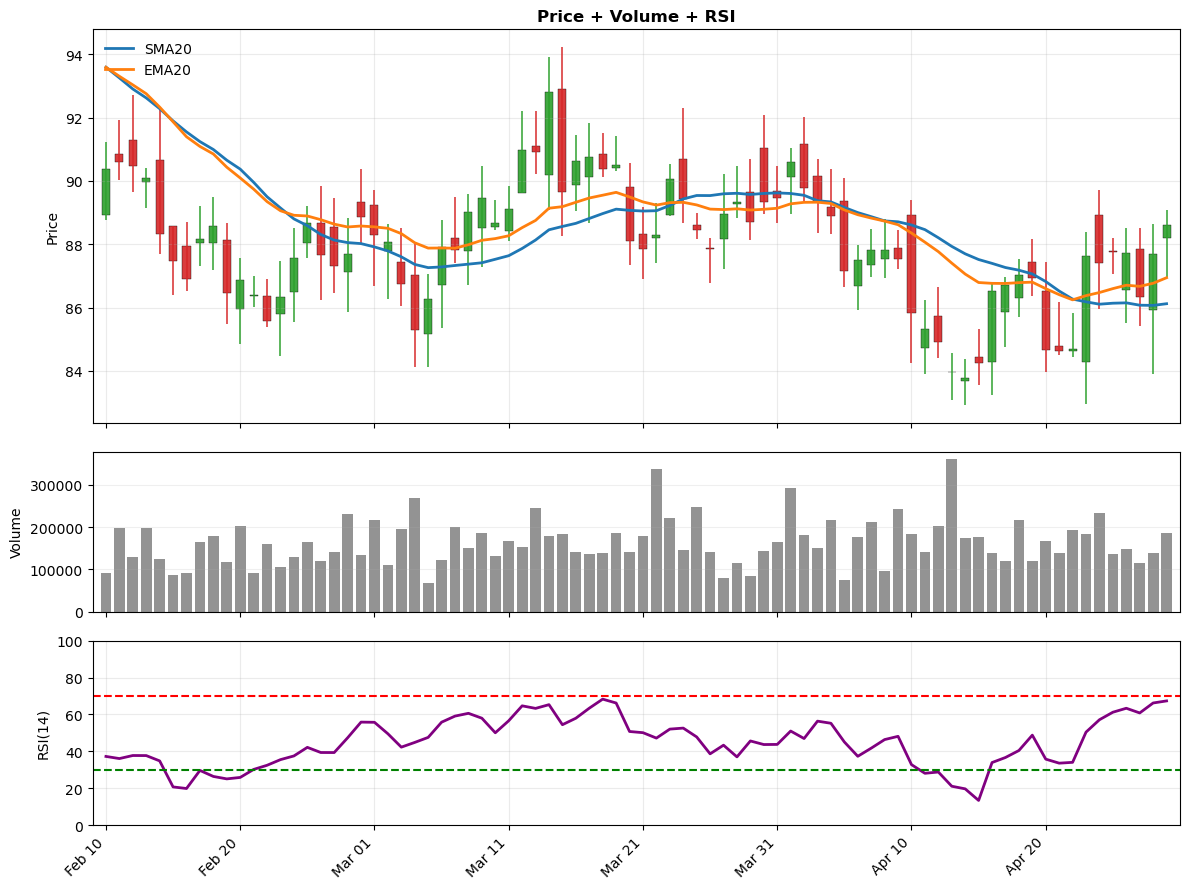

In [5]:
print('=== MULTI-PANEL DASHBOARD ===')
d = df.iloc[-80:].copy()
x = np.arange(len(d))

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True, gridspec_kw={'height_ratios':[3.2, 1.3, 1.5]})
ax_price, ax_vol, ax_rsi = axes

plot_candles(ax_price, d, width=0.6)
ax_price.plot(x, d['SMA20'], color='#1f77b4', lw=2, label='SMA20')
ax_price.plot(x, d['EMA20'], color='#ff7f0e', lw=2, label='EMA20')
ax_price.set_title('Price + Volume + RSI', fontweight='bold')
ax_price.set_ylabel('Price')
ax_price.grid(True, alpha=0.25)
ax_price.legend(frameon=False, loc='upper left')

ax_vol.bar(x, d['Volume'], color='0.4', alpha=0.7)
ax_vol.set_ylabel('Volume')
ax_vol.grid(True, alpha=0.2, axis='y')

ax_rsi.plot(x, d['RSI14'], color='purple', lw=2)
ax_rsi.axhline(70, color='red', linestyle='--', lw=1.5)
ax_rsi.axhline(30, color='green', linestyle='--', lw=1.5)
ax_rsi.set_ylim(0, 100)
ax_rsi.set_ylabel('RSI(14)')
ax_rsi.grid(True, alpha=0.25)

step = 10
ax_rsi.set_xticks(np.arange(0, len(d), step))
ax_rsi.set_xticklabels([dt.strftime('%b %d') for dt in d.index[::step]], rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Practice + Quick Reference
### Practice
1. Replace synthetic data with real OHLCV CSV (Yahoo/AlphaVantage export).
2. Add Bollinger Bands (SMA ± 2*std).
3. Add MACD and a signal line in a new panel.

### Quick reference
```python
# SMA
df['SMA20'] = df['Close'].rolling(20).mean()
# EMA
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
# RSI
# (see function above)
```
